$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# Assignment 3: Neural Network Regression

*Alexander Day*

## Overview

In this assignment we compare the root mean square error obtained by fitting a model to a dataset using linear regression and neural networks. The methods used in constructing a linear model are identical to the previously used methods with the exception that we now no longer restrict the weight penalty, lambda, to be 0. The neural network that is used to construct a model is examined further here to  provide a rough overview of how it works to construct a model.

To start, here is a visualization of a neural network, in which commonly used parameters such as the weights, $\wv$, as well as the inputs, $\xv$, and targets, $\yv$, can be seen

<img src="http://www.cs.colostate.edu/~anderson/cs480/notebooks/nnTwoLayer.png">

Now let's address some of the items that are unfamiliar in the image as well as the operation of the neural network. The hidden layers are the layers between the inputs and the outputs, here these are shown in as the yellow circles. Note that if a network consists of more than one hidden layer these would just be connected from this first one on through the network to the outputs. Each hidden layer is composed of a number of units, again a quantity that is variable depending on how the user wishes to structure the network. The idea behind having these hidden layers is that each layer can optimize a part of the training to construct a nonlinear fit to the data. This is done by having a nonlinear function in each unit in a hidden layer. The nonlinear function used in this assignment is the hyperbolic tangent, although any sigmoid function could be used. The function used in the hidden layers is known as the activation function. A benefit to using such functions in the hidden layers is that they have well-behaved derivatives that asymptote to 0. In each unit we are optimizing by taking derivatives to update the neural network in order to obtain a minimal root mean square error in the targets and predicted values. This optimization is accomplished through a forward pass and back propagation. The forward pass is accomplished by minimizing the activation function and  back propagation is accomplished by traveling along the direction of the gradient to locate minima using the scaled conjugate gradient algorithm. The forward pass and back propogation are accomplished using the following equations

$$
\begin{align}
\Zv &= h( \tilde{\Xv} \Vv)\\
        \Yv &= \tilde{\Zv} \Wv\\
            \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \left ( (\Tv - \Yv) \hat{\Wv}^T \cdot  (1-\Zv^2) \right )\\
                 \Wv & \leftarrow \Wv + \rho_o \frac{1}{N}  \frac{1}{K} \tilde{\Zv}^T (\Tv - \Yv)
\end{align}
$$

The first two represent the forward pass, where ~ over a variable represents that it has been augmented by adding a column of ones. The last two equations are the backward pass and this is the process that is accomplished through the use of the scaled conjugate gradient algorithm.

## Method

Comparison between the predictive models derived from least squares linear regression and the neural network is accomplished with the following functions. In particular it is the trainValidateTestKFolds function that takes as arguments a training function and an evaluation function that are also defined below. The function trainValidateTestKFolds then loops through k-folds of the data partitioning them into train, validate, and test sets. The parameter set argument defines the parameters to be used for the training and evaluation functions. When using the linear train and evaluate functions this parameter set is a list of values of lambda to use when training the linear model. When using it on a neural network the parameter set is a list of two lists, the first being different structures (number of units in each hidden layer, example [5,5,5] is three hidden layers each of 5 units) and the second list is of the numbers of iterations to train the neural network. 

In [4]:
#library imports to support defined functions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn
import itertools

def trainLinear(X,T,parameters):
    lamb = parameters
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.hstack((np.ones((n,1)), (X - means)/stds))
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1) + lambDiag, np.dot(Xs1.T,T))[0]
    model = {'w': w, 'means':means, 'stds':stds}
    return model

def evaluateLinear(model,X,T):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack(( columnOfOnes, (X-model['means'])/model['stds']))
    predicted = np.dot( Xs1, model['w'] )
    return np.sqrt(np.mean((T-predicted)**2 ))

def trainNN(X,T,parameters):
    nnet = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[0]) # ERROR- originally was T.shape[1]
    return nnet.train(X,T,parameters[1])

def evaluateNN(model,X,T):
    predicted = model.use(X)
    return np.sqrt(np.mean((T-predicted)**2 ))

def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []
    # For each test fold
    for testFold in range(nFolds):
        # For each set of parameter values, called parmSet
        lowError = np.inf
        for parmSet in parameterSets:
            # Find best set of parameter values
            # For each validate fold (except when same as test fold)
            errors = []
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Use trainf to fit model to training data using parmSet
                model = trainf(Xtrain,Ttrain,parmSet)
                # Calculate the error of this model by calling evaluatef with 
                  # the model and validation data
                errors.append(evaluatef(model,Xvalidate,Tvalidate))
            # Calculate the mean of these errors.
            mean = np.array(errors).mean(0)
            # If this error is less than the previously best error for parmSet, 
              # update best parameter values and best error
            if mean < lowError:
                lowError = mean
                bestParmSet = parmSet
        # Make a new set of training data by concatenating the training and 
          # validation data from previous step.
        Xnew = np.vstack([Xtrain,Xvalidate])
        Tnew = np.vstack([Ttrain,Tvalidate])
        # Retrain, using trainf again, to fit a new model to this new training data.
        newModel = trainf(Xnew,Tnew,bestParmSet)
        # Calculate error of this new model on the test data, and also on the new training data.
        errorNewTest = evaluatef(newModel,Xtest,Ttest)
        errorNewTrain = evaluatef(newModel,Xnew,Tnew)
        # Construct a list of the best parameter values with this training error, 
            # the mean of the above validation errors, and the testing error
        bestParamList = [bestParmSet,errorNewTrain,lowError,errorNewTest]
        # Print this list if verbose == True
        if verbose: print(bestParamList)
        # Append this list to a result list
        results.append(bestParamList)
    # Return this result list
    return results

## Data

For this assignment I used a dataset of recorded speech signals using a telemonitoring device to predict the clinician's Parkinson's disease sympton score on the UPDRS scale. The dataset is from the UCI machine learning repository and can be downloaded at https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/. The dataset was created by Athanasios Tsanas and Max Little of the University of Oxford, in collaboration with 10 medical centers in the US and Intel Corporation who developed the telemonitoring device to record the speech signals. 

The dataset has 5875 instances of 19 attribute variables that are used to predict can be used to predict both motor UPDRS score as well as a total UPDRS score. The total number of instances can be reduced by taking the mean across all attributes for each test subject.There are roughly 140 samples for each of 42 subjects therefore the data set can be reduced to one of 42 instances. This smaller dataset is used in this assignment as it eases the calculations in the neural network without randomly discarding any instances. Also, even though the data can be used to predict both motor UPDRS and total UPDRS symptom scores, in this assignment we only focus on predicting total UPDRS score. The attributes used in constructing a model  to predict total UPDRS score are the following:

    Age - Subject age 

    Sex - Subject gender '0' - male, '1' - female 

    Test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment. 

    Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP - Several measures of variation in fundamental frequency 

    Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA - Several measures of variation in
    amplitude 

    NHR, HNR - Two measures of ratio of noise to tonal components in the voice 

    RPDE - A nonlinear dynamical complexity measure 

    DFA - Signal fractal scaling exponent 

    PPE - A nonlinear measure of fundamental frequency variation  

In [2]:
# reads in data set and reduces to an array of mean attribute
# values grouped by first column, the subject identifier
def readTelemonitoringData(filename='parkinsons_updrs.data'):
    f = open(filename,'r')
    header = f.readline()
    names = header.strip().split(',')[1:]
    data = np.loadtxt(f,usecols=range(22),delimiter = ',')
    print("Read",data.shape[0],"rows and",data.shape[1],"columns from",filename," before averaging.")
    avgs = []
    uniqs = np.unique(data[:,0])
    for x in uniqs:
        forx = data[data[:,0] == x, 1:]
        avgs.append([x] + np.mean(forx,0).tolist())
    data = np.array(avgs)
    print("After averaging there are ",data.shape[0],"rows and ", data.shape[1],"columns.")
    X = np.hstack([data[:,1:4],data[:,6:]])
    T = data[:,4:5]
    Xnames = np.hstack([names[:3],names[5:]])
    Tnames = names[4:5]
    return X,T, Xnames, Tnames

In [34]:
X,T,Xnames,Tnames = readTelemonitoringData()
X.shape, T.shape

Read 5875 rows and 22 columns from parkinsons_updrs.data  before averaging.
After averaging there are  42 rows and  22 columns.


((42, 19), (42, 1))

Now that we have all of the data organized, let's take a look at some plots of the predictor attributes.

The plots below show the target value, total UPDRS, against each of the predictor variable. I choose to omit plotting the first two predictor variables as sex and age are discrete values that do not add much to the visualization of the data. Additionally, the different measures of jitter and shimmer are plotted on the same plot to provide an more general view of these predictor variables.

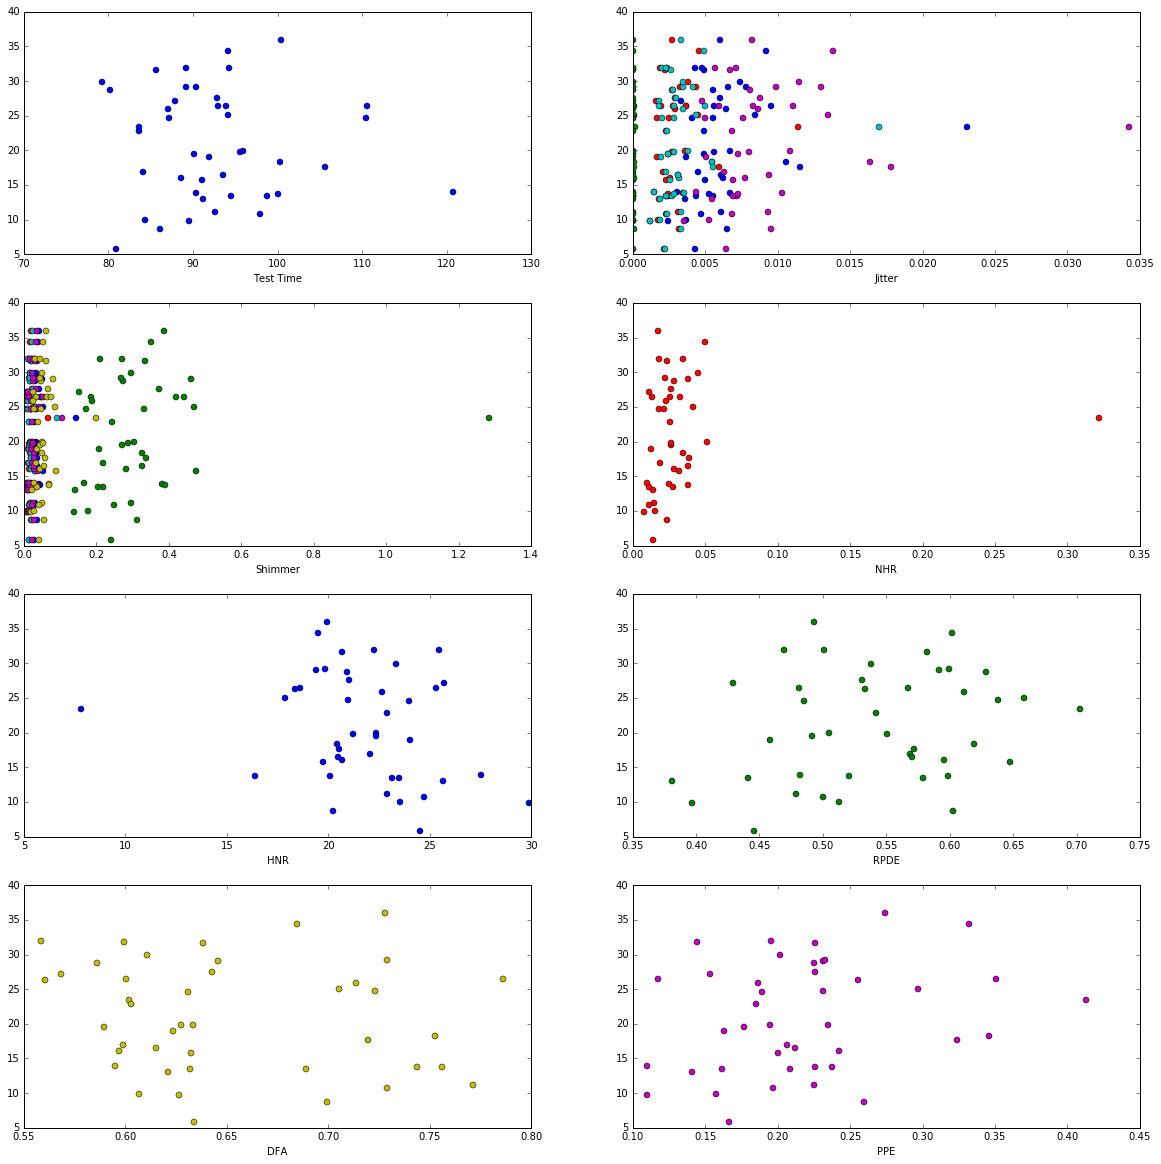

In [5]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(X[:,2], T, 'o')
plt.xlabel("Test Time")
for i in range(3,8):
    plt.subplot(4,2,2)
    plt.plot(X[:,i], T, 'o')
    plt.xlabel("Jitter")
for i in range(8,14):
    plt.subplot(4,2,3)
    plt.plot(X[:,i], T, 'o')
    plt.xlabel("Shimmer")
colors = ['ro','bo','go','yo','mo']
for i in range(14,19):
    plt.subplot(4,2,i-10)
    plt.plot(X[:,i], T, colors[i-14])
    plt.xlabel(Xnames[i])

Looking at the target values plotted against the predictor variables reveals a slight linear relationship amongst some of the predictor variables and the target, such as NHR. However, it does appear that there is correlation among the predictor variables, as can be seen in the grouped plots of shimmer and jitter, leading me to hypothesize that the most important weight in the linear model will be the bias weight.

In this case we may be able to perform some pruning techniques to reduce the number of predictor variables to the ones that are having the greatest affect in predicting the total UPDRS symptom score.

## Results

First let's fit a linear model to the data using values for lambda from 1 to 100 in increments of 10.

In [11]:
linearResult = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,101,10),nFolds=5,shuffle=False)
print('Linear Model\nlambda, train, validate, test RMSE')
for x in linearResult:
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))

Linear Model
lambda, train, validate, test RMSE
100.00    7.291   8.703   7.868
10.00    6.771   8.424   8.005
100.00    7.070   8.213   9.362
100.00    7.543   8.769   6.970
100.00    6.824   7.881   9.772


It appears that a higher value of lambda is yielding a lower error. So let's go a little extreme and try values of lambda from 1-1000 in increments of 100. This should offer a better idea of the best lambda for predicting total UPDRS from this dataset.

In [13]:
linearResult = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,1001,100),nFolds=5,shuffle=False)
print('Linear Model\nlambda, train, validate, test RMSE')
for x in linearResult:
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))

Linear Model
lambda, train, validate, test RMSE
300.00    7.509   8.552   7.734
500.00    7.769   8.473   7.551
900.00    7.273   8.108   9.673
200.00    7.643   8.767   7.097
100.00    6.824   7.881   9.772


From these values of lambda it no longer appears that a larger value of lambda  is offering any significant advantage in constructing the model. While the average test RMSE was decreased, the decrease is not very large. Therefore it appears that a strong predictor in this model is the bias weight. To examine the linear model closely let's construct one that is independent of the testValidatePartionKFolds function. To do this, we use the results of the evaluation over many possible values to select as the lambda a value of 500. We will train on the first 32 samples and test on the remaining 10.

In [14]:
linearModel = trainLinear(X[0:32,:],T[0:32,:],500)
linearError = evaluateLinear(linearModel,X[32:,:],T[32:,:])
print('Weights: ')
print('Bias has weight ',linearModel['w'][0])
for i in range(19):
    print(Xnames[i],' has weight ',linearModel['w'][i+1])
print('\nRMSE: ',linearError)

Weights: 
Bias has weight  [ 19.19824828]
age  has weight  [ 0.16771201]
sex  has weight  [-0.06678705]
test_time  has weight  [-0.01725802]
Jitter(%)  has weight  [ 0.05276692]
Jitter(Abs)  has weight  [ 0.02785685]
Jitter:RAP  has weight  [ 0.0420747]
Jitter:PPQ5  has weight  [ 0.05477802]
Jitter:DDP  has weight  [ 0.04208154]
Shimmer  has weight  [ 0.05940976]
Shimmer(dB)  has weight  [ 0.06635962]
Shimmer:APQ3  has weight  [ 0.04126671]
Shimmer:APQ5  has weight  [ 0.05597047]
Shimmer:APQ11  has weight  [ 0.08675825]
Shimmer:DDA  has weight  [ 0.04127133]
NHR  has weight  [ 0.07723758]
HNR  has weight  [-0.06931036]
RPDE  has weight  [ 0.09388586]
DFA  has weight  [-0.10027412]
PPE  has weight  [ 0.05696204]

RMSE:  9.26332368162


Looking at the weights for each predictor variable it becomes clear that the bias weight has the largest magnitude supporting the fact that a large value of lambda yields a better linear model, as this model then depends more on the bias weight.

Now let's turn our attention to building a neural network to predict the UPDRS total. First we will try some various parameters to see how to best construct the network.

In [19]:
parms = list(itertools.product([2,5,10,[2,2,2,2],[2,5,2],[10,10,10]], [20,100,500]))
nnResult = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms,nFolds=5,shuffle=False)
print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in nnResult:
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

NN Model
(hidden units, iterations), train, validate, test RMSE
(10, 500)  		    7.042   7.971   8.309
(5, 100)  		    7.168   8.309   8.475
([2, 2, 2, 2], 500)  		    7.339   8.058   9.813
([2, 2, 2, 2], 500)  		    7.841   8.562   7.432
(2, 500)  		    7.074   7.870   9.075


From this first attempt we can conclude that the number of iterations should be closer to 500 as this tended to produce a lower RMSE. Additionally, the test RMSE is noticeably lower across the networks that have simpler hidden structures, performing best with the one that have four hidden layers where each layer has 2 units. Now with this information let's try to pick parameters that may be able to decrease the test RMSE even more.

In [28]:
parms = list(itertools.product([[2,2,2],[3,3,3],[3,3,3,3],[2,2,2,2],[2,2,2,2,2],[2,2,2,2,2,2]], [500,800]))
nnResult = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms,nFolds=5,shuffle=False)
print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in nnResult:
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

NN Model
(hidden units, iterations), train, validate, test RMSE
([3, 3, 3], 800)  		    6.956   7.872   8.004
([2, 2, 2, 2, 2, 2], 800)  		    7.806   8.300   7.634
([2, 2, 2, 2], 800)  		    7.409   8.026   9.900
([2, 2, 2, 2, 2], 800)  		    7.717   8.435   7.349
([3, 3, 3, 3], 800)  		    7.415   7.949   9.519


Now the lowest test RMSE occurs with a network that was trained with 800 iterations and again a symmetric structure of hidden units, however the networks with more hidden layers performed better. For a final test we will choose a set of parameters that seems to perform the best, namely training for more iterations, let's use 1000, and a structure of many hidden layers with a few hidden units, such as [2,2,2,2,2,2]. The data to be used in constructing this network will have the same split as above in the linear model, namely 32 training samples and 10 test samples.

In [40]:
nnet = trainNN(X[:32,:],T[:32,:],[[2,2,2,2,2,2],1000])
Y = nnet.use(X[32:,:])
nnError = evaluateNN(nnet,X[32:,:],T[32:,:])
print('The test RMSE for the neural network is ',nnError)

The test RMSE for the neural network is  9.50152064605


So from this one run with the given structure the test RMSE is very similar to that of the model built using purely linear regression techniques. Given that the range of values for the total UPDRS symptom score is between 0 and 40 an RMSE of 9.5 is not all that great.

The reason for the inability to obtain a very low RMSE from the techniques used most likely lies in the fact that the data does not yield an easily constructable model that can be used to predict the UPDRS symptom score. One way to improve this could be to use all 5785 instances instead of averaging the instances by test subject. However, training the neural network on 5785 would take quite a long time.

Now let's take a look at some visualization of the neural network. First let's use the draw function that is available in the neural network class.

44.0 47 0.852818010107 1.49691461666


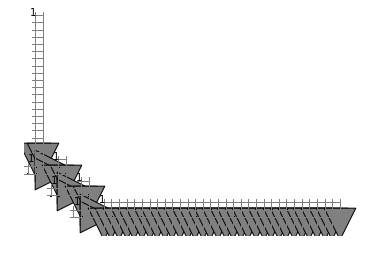

In [41]:
nnet.draw()

From the above plot it is clear that the bias weight is having a huge effect on the output as opposed to the other predictor attribute weights. This is similar to what was occuring in the linear model. To me this means that the techniques being used to fit a model to the data may not be the most appropriate for this data set. In the dataset description, the researchers discuss having used a support vector machine to predict total UPDRS symptom score, this may be the better method for using this data. 

As another way to visualize the results of using the neural network on the data, the following plot shows the UPDRS score predicted by the network versus the actual target values.

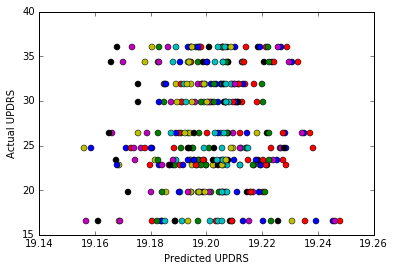

In [27]:
plt.plot(Y,T[32:,:],'o')
plt.xlabel("Predicted UPDRS")
plt.ylabel("Actual UPDRS")

In [23]:
np.average(T)

20.95345589651399

This plot shows how the neural network is truly not doing a great job of fitting the test data. In fact as it appears we may be better just using the mean of the distribution, 20.95,  to predict UPDRS scores, as all of our predicted values are fall between 19.15 and 19.25. 

To conclude, I feel that I probably could have found a dataset that does a better job of showing the power of neural networks. In fact, in the final run on the 42 data sets that were partitioned into a training set of size 32 and a test set of size 10, the linear regression obtained a lower RMSE. Another option to improve the performance of the neural network would be to use all of the 5875 instances to train the network or construct subsets of the data in a different manner than was done in this assignment.

## Grading

In [5]:
%run -i "A3grader.py"

 Testing: result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                  range(0,101,10),nFolds=5,shuffle=False)
 Result is
    10   3.158   4.132   2.414
    20   4.368   5.021   3.641
    10   3.245   4.178   5.03
    20   4.448   6.07   2.024
    20   2.426   2.972   10.89
20/20 points. First column, of best lambda values, is correct.
20/20 points. Columns of RMSE values are correct.

 Testing:
   import itertools
   parms = list(itertools.product([[5],[5,5],[2,2,2]], [10,50,100,200]))
   te = []
   for rep in range(5):
       result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                        parms,
                                        nFolds=4,shuffle=False)
       resulte = np.array([r[1:] for r in result])
       meanTestRMSE = resulte[:,-1].mean()
       print('     ',meanTestRMSE)
       te.append(meanTestRMSE)
      1.6880459077
      1.27071454879
      1.20294918456
      1.59242143198
      1.88251542713
40/40 points. Mea